# Спринт 9 «Введение в машинное обучение»

# Проект «Рекомендация тарифов»

## Навигация

1. [Описание проекта](#Описание-проекта)
1. [Описание данных](#Описание-данных)
1. [Исследование данных](#Исследование-данных)
1. [Исследование моделей](#Исследование-моделей)
   - [Исследование DecisionTreeClassifier](#Исследование-DecisionTreeClassifier)
   - [Исследовние RandomForestClassifier](#Исследовние-RandomForestClassifier)
1. [Проверка модели на тестовой выборке](#Проверка-модели-на-тестовой-выборке)
1. [Общий вывод](#Общий-вывод)

## Описание проекта

[к навигации](#Навигация)

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф.

## Описание данных

[к навигации](#Навигация)

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
- `сalls` — количество звонков,
- `minutes` — суммарная длительность звонков в минутах,
- `messages` — количество sms-сообщений,
- `mb_used` — израсходованный интернет-трафик в Мб,
- `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [2]:
RANDOM_STATE = 42

## Исследование данных

[к навигации](#Навигация)

In [3]:
data = pd.read_csv(
    os.path.join('..', 'datasets', 'users_behavior.csv'),
    dtype={
        'calls': 'int16',
        'minutes': 'float32',
        'messages': 'int16',
        'mb_used': 'float32',
        'is_ultra': 'int8',
    },
)
data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40,311.899994,83,19915.419922,0
1,85,516.750000,56,22696.960938,0
2,77,467.660004,86,21060.449219,0
3,106,745.530029,81,8437.389648,1
4,66,418.739990,1,14502.750000,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   int16  
 1   minutes   3214 non-null   float32
 2   messages  3214 non-null   int16  
 3   mb_used   3214 non-null   float32
 4   is_ultra  3214 non-null   int8   
dtypes: float32(2), int16(2), int8(1)
memory usage: 40.9 KB


In [5]:
data.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208771,38.281269,17207.673828,0.306472
std,33.236368,234.569870,36.148326,7570.968262,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.574997,9.000000,12491.902588,0.000000
50%,62.000000,430.600006,30.000000,16943.234375,0.000000
75%,82.000000,571.927521,57.000000,21424.699707,1.000000
max,244.000000,1632.060059,224.000000,49745.730469,1.000000


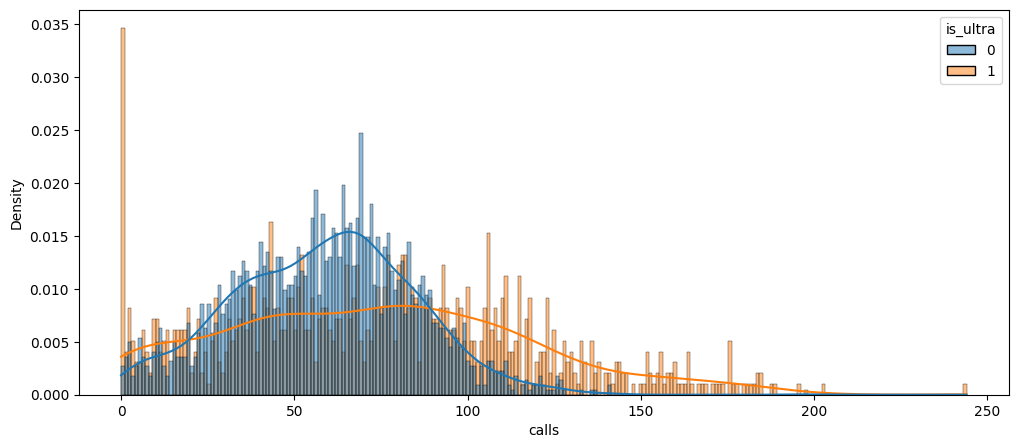

In [6]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(
    data=data,
    x='calls',
    hue='is_ultra',
    bins=245,
    stat='density',
    common_norm=False,
    kde=True,
    ax=ax,
);

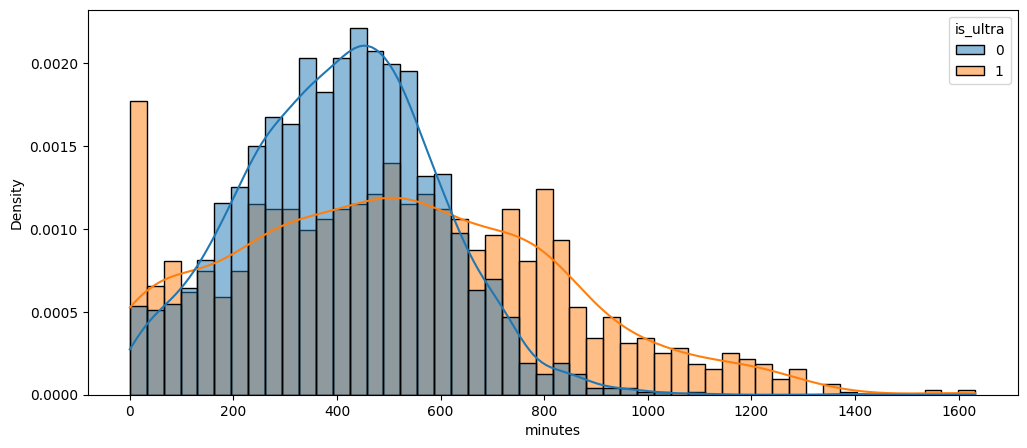

In [7]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(
    data=data,
    x='minutes',
    hue='is_ultra',
    bins=50,
    stat='density',
    common_norm=False,
    kde=True,
    ax=ax,
);

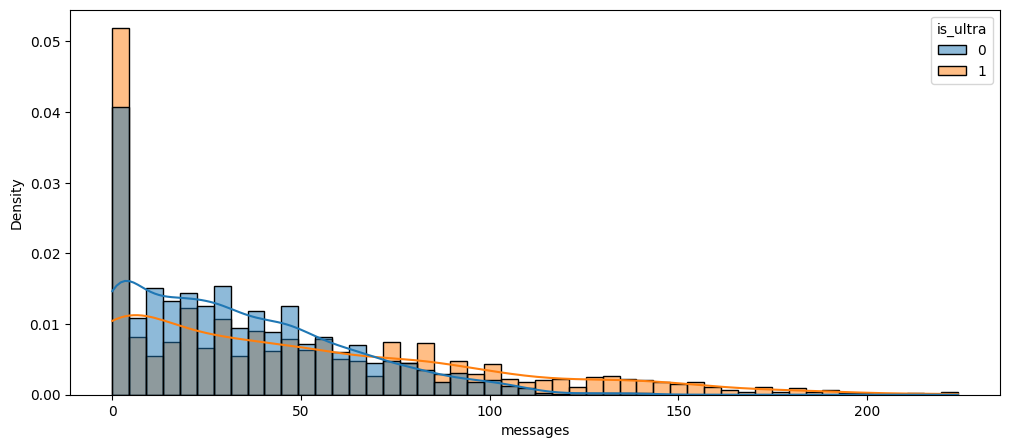

In [8]:
fig, ax = plt.subplots(figsize=(12, 5))

sns.histplot(
    data=data,
    x='messages',
    hue='is_ultra',
    bins=50,
    stat='density',
    common_norm=False,
    kde=True,
    ax=ax,
);

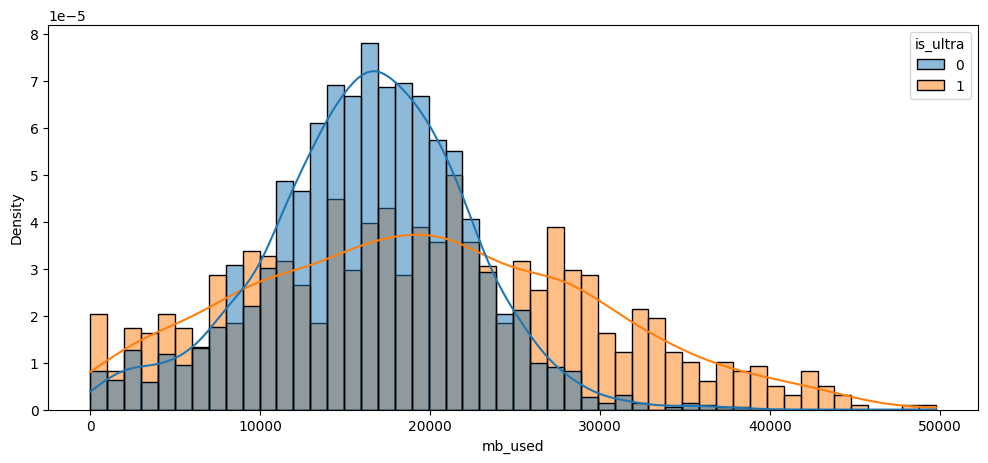

In [9]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(
    data=data,
    x='mb_used',
    hue='is_ultra',
    bins=50,
    stat='density',
    common_norm=False,
    kde=True,
    ax=ax,
);

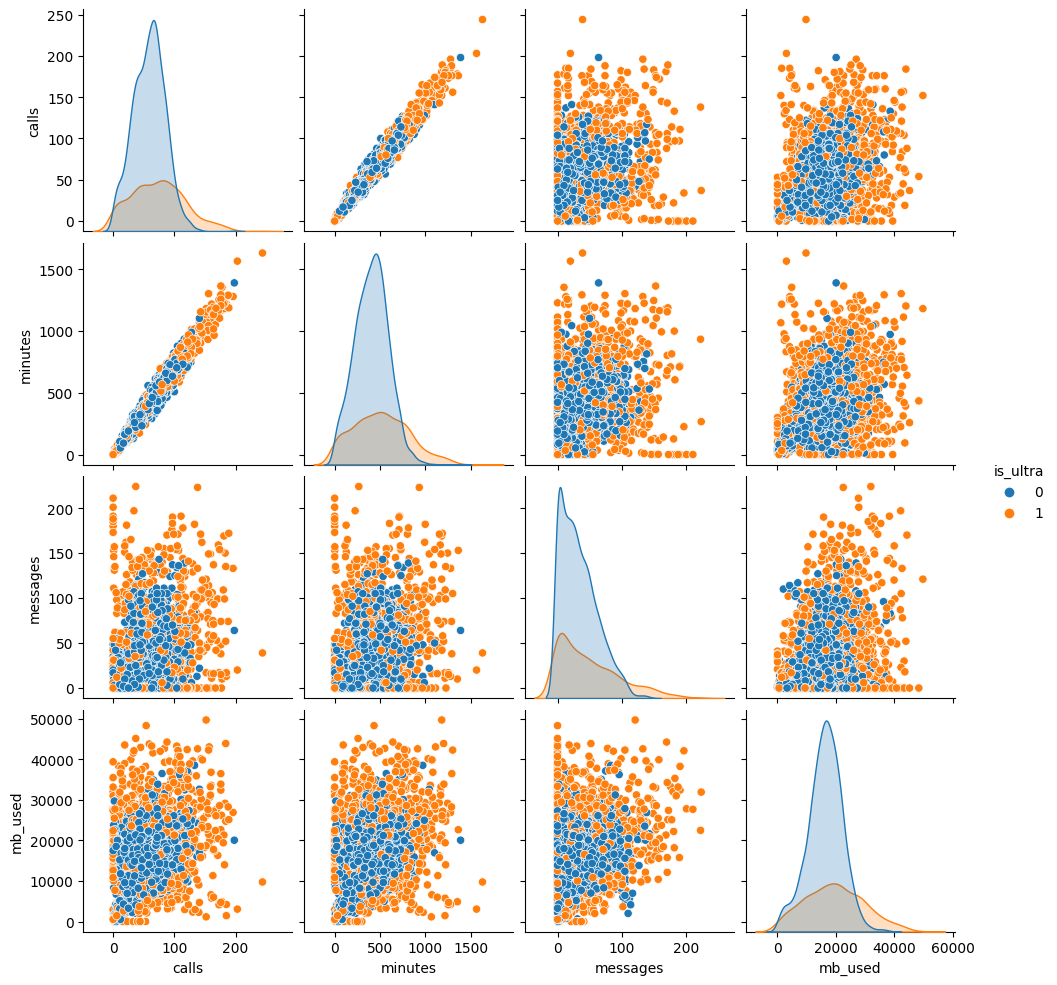

In [10]:
sns.pairplot(data, hue='is_ultra')

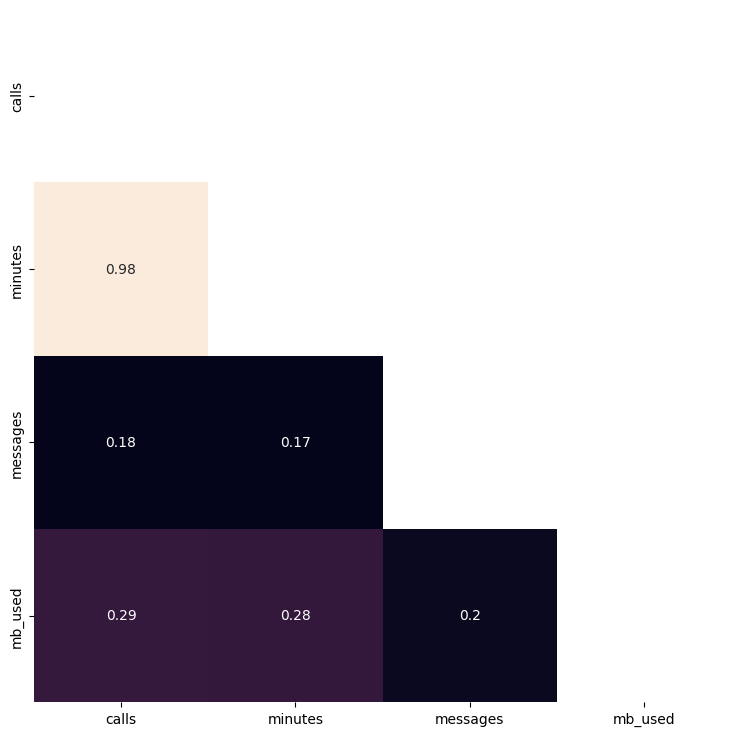

In [11]:
corr = data.drop(columns='is_ultra').corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(corr, mask=mask, annot=True, cbar=False, ax=ax);

## Исследование моделей

[к навигации](#Навигация)

In [12]:
y = data['is_ultra']
X = data.drop(columns='is_ultra')

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify=y,
    random_state=RANDOM_STATE,
)

### Исследование DecisionTreeClassifier

[к навигации](#Навигация)

In [13]:
%%time
# ОБА КОРРЕЛИРОВАННЫХ ПРИЗНАКА 'calls' и 'minutes'

# поиск лучших гиперпараметров с кросс-валидацией
search = GridSearchCV(
    estimator=DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE),
    param_grid={
        'max_depth': np.arange(2, 13),
        'min_weight_fraction_leaf': np.logspace(-3, -1, num=5),
        'min_impurity_decrease': np.logspace(-3, -1, num=5),
    },
    scoring='balanced_accuracy',
    n_jobs=-1,
    cv=StratifiedShuffleSplit(
        test_size=0.2,
        random_state=RANDOM_STATE,
    ),
)
search.fit(X_train, y_train)


tree_model_v1 = search.best_estimator_

print('Лучшие гиперпараметры:')
for param, value in search.best_params_.items():
    print(f'{param}: {value}')
print(f'Лучший score: {search.best_score_}\n')

y_pred = tree_model_v1.predict(X_test)
print(classification_report(y_test, y_pred))

Лучшие гиперпараметры:
max_depth: 9
min_impurity_decrease: 0.001
min_weight_fraction_leaf: 0.0031622776601683794
Лучший score: 0.742656578734423

              precision    recall  f1-score   support

           0       0.84      0.78      0.81       558
           1       0.57      0.67      0.62       246

    accuracy                           0.75       804
   macro avg       0.71      0.73      0.72       804
weighted avg       0.76      0.75      0.75       804

CPU times: total: 953 ms
Wall time: 15.3 s


In [14]:
%%time
# БЕЗ ПРИЗНАКА 'calls'

X_train_drop_calls = X_train.drop('calls', axis=1)
X_test_drop_calls = X_test.drop('calls', axis=1)
# поиск лучших гиперпараметров с кросс-валидацией
search = GridSearchCV(
    estimator=DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE),
    param_grid={
        'max_depth': np.arange(2, 13),
        'min_weight_fraction_leaf': np.logspace(-3, -1, num=5),
        'min_impurity_decrease': np.logspace(-3, -1, num=5),
    },
    scoring='balanced_accuracy',
    n_jobs=-1,
    cv=StratifiedShuffleSplit(
        test_size=0.2,
        random_state=RANDOM_STATE,
    ),
)
search.fit(X_train_drop_calls, y_train)


tree_model_v2 = search.best_estimator_

print('Лучшие гиперпараметры:')
for param, value in search.best_params_.items():
    print(f'{param}: {value}')
print(f'Лучший score: {search.best_score_}\n')

y_pred = tree_model_v2.predict(X_test_drop_calls)
print(classification_report(y_test, y_pred))

Лучшие гиперпараметры:
max_depth: 9
min_impurity_decrease: 0.001
min_weight_fraction_leaf: 0.01
Лучший score: 0.7426929923935912

              precision    recall  f1-score   support

           0       0.85      0.72      0.78       558
           1       0.53      0.72      0.61       246

    accuracy                           0.72       804
   macro avg       0.69      0.72      0.69       804
weighted avg       0.75      0.72      0.73       804

CPU times: total: 969 ms
Wall time: 6 s


In [15]:
%%time
# БЕЗ ПРИЗНАКА 'minutes'

X_train_drop_minutes = X_train.drop(columns='minutes')
X_test_drop_minutes = X_test.drop(columns='minutes')
# поиск лучших гиперпараметров с кросс-валидацией
search = GridSearchCV(
    estimator=DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE),
    param_grid={
        'max_depth': np.arange(2, 13),
        'min_weight_fraction_leaf': np.logspace(-3, -1, num=5),
        'min_impurity_decrease': np.logspace(-3, -1, num=5),
    },
    scoring='balanced_accuracy',
    n_jobs=-1,
    cv=StratifiedShuffleSplit(
        test_size=0.2,
        random_state=RANDOM_STATE,
    ),
)
search.fit(X_train_drop_minutes, y_train)


tree_model_v3 = search.best_estimator_

print('Лучшие гиперпараметры:')
for param, value in search.best_params_.items():
    print(f'{param}: {value}')
print(f'Лучший score: {search.best_score_}\n')

y_pred = tree_model_v3.predict(X_test_drop_minutes)
print(classification_report(y_test, y_pred))

Лучшие гиперпараметры:
max_depth: 9
min_impurity_decrease: 0.001
min_weight_fraction_leaf: 0.0031622776601683794
Лучший score: 0.7419768570966176

              precision    recall  f1-score   support

           0       0.86      0.77      0.81       558
           1       0.58      0.71      0.64       246

    accuracy                           0.75       804
   macro avg       0.72      0.74      0.72       804
weighted avg       0.77      0.75      0.76       804

CPU times: total: 891 ms
Wall time: 5.34 s


### Исследовние RandomForestClassifier

[к навигации](#Навигация)

In [16]:
%%time
# ОБА КОРРЕЛИРОВАННЫХ ПРИЗНАКА 'calls' и 'minutes'

# поиск лучших гиперпараметров с кросс-валидацией
search = GridSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE),
    param_grid={
        'max_depth': np.arange(2, 13),
        'min_weight_fraction_leaf': np.logspace(-3, -1, num=5),
        'min_impurity_decrease': np.logspace(-3, -1, num=5),
    },
    scoring='balanced_accuracy',
    n_jobs=-1,
    cv=StratifiedShuffleSplit(
        test_size=0.2,
        random_state=RANDOM_STATE,
    ),
)
search.fit(X_train, y_train)


forest_model_v1 = search.best_estimator_

print('Лучшие гиперпараметры:')
for param, value in search.best_params_.items():
    print(f'{param}: {value}')
print(f'Лучший score: {search.best_score_}\n')

y_pred = forest_model_v1.predict(X_test)
print(classification_report(y_test, y_pred))

Лучшие гиперпараметры:
max_depth: 10
min_impurity_decrease: 0.001
min_weight_fraction_leaf: 0.0031622776601683794
Лучший score: 0.7541268813723903

              precision    recall  f1-score   support

           0       0.85      0.86      0.85       558
           1       0.67      0.65      0.66       246

    accuracy                           0.79       804
   macro avg       0.76      0.75      0.76       804
weighted avg       0.79      0.79      0.79       804

CPU times: total: 5.89 s
Wall time: 3min 2s


In [17]:
%%time
# БЕЗ ПРИЗНАКА 'calls'

X_train_drop_calls = X_train.drop(columns='calls')
X_test_drop_calls = X_test.drop(columns='calls')
# поиск лучших гиперпараметров с кросс-валидацией
search = GridSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE),
    param_grid={
        'max_depth': np.arange(2, 13),
        'min_weight_fraction_leaf': np.logspace(-3, -1, num=5),
        'min_impurity_decrease': np.logspace(-3, -1, num=5),
    },
    scoring='balanced_accuracy',
    n_jobs=-1,
    cv=StratifiedShuffleSplit(
        test_size=0.2,
        random_state=RANDOM_STATE,
    ),
)
search.fit(X_train_drop_calls, y_train)


forest_model_v2 = search.best_estimator_

print('Лучшие гиперпараметры:')
for param, value in search.best_params_.items():
    print(f'{param}: {value}')
print(f'Лучший score: {search.best_score_}\n')

y_pred = forest_model_v2.predict(X_test_drop_calls)
print(classification_report(y_test, y_pred))

Лучшие гиперпараметры:
max_depth: 8
min_impurity_decrease: 0.001
min_weight_fraction_leaf: 0.001
Лучший score: 0.7546670173167179

              precision    recall  f1-score   support

           0       0.84      0.87      0.85       558
           1       0.68      0.62      0.65       246

    accuracy                           0.79       804
   macro avg       0.76      0.74      0.75       804
weighted avg       0.79      0.79      0.79       804

CPU times: total: 5.92 s
Wall time: 2min 42s


In [18]:
%%time
# БЕЗ ПРИЗНАКА 'minutes'

X_train_drop_minutes = X_train.drop(columns='minutes')
X_test_drop_minutes = X_test.drop(columns='minutes')
# поиск лучших гиперпараметров с кросс-валидацией
search = GridSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE),
    param_grid={
        'max_depth': np.arange(2, 13),
        'min_weight_fraction_leaf': np.logspace(-3, -1, num=5),
        'min_impurity_decrease': np.logspace(-3, -1, num=5),
    },
    scoring='balanced_accuracy',
    n_jobs=-1,
    cv=StratifiedShuffleSplit(
        test_size=0.2,
        random_state=RANDOM_STATE,
    ),
)
search.fit(X_train_drop_minutes, y_train)

forest_model_v3 = search.best_estimator_

print('Лучшие гиперпараметры:')
for param, value in search.best_params_.items():
    print(f'{param}: {value}')
print(f'Лучший score: {search.best_score_}\n')

y_pred = forest_model_v3.predict(X_test_drop_minutes)
print(classification_report(y_test, y_pred))

Лучшие гиперпараметры:
max_depth: 12
min_impurity_decrease: 0.001
min_weight_fraction_leaf: 0.0031622776601683794
Лучший score: 0.7501497005988024

              precision    recall  f1-score   support

           0       0.85      0.86      0.86       558
           1       0.68      0.66      0.67       246

    accuracy                           0.80       804
   macro avg       0.76      0.76      0.76       804
weighted avg       0.80      0.80      0.80       804

CPU times: total: 6.28 s
Wall time: 2min 42s


## Проверка модели на тестовой выборке

[к навигации](#Навигация)

In [19]:
y_proba = forest_model_v1.predict_proba(X_test)[:, 1]
y_pred = forest_model_v1.predict(X_test)

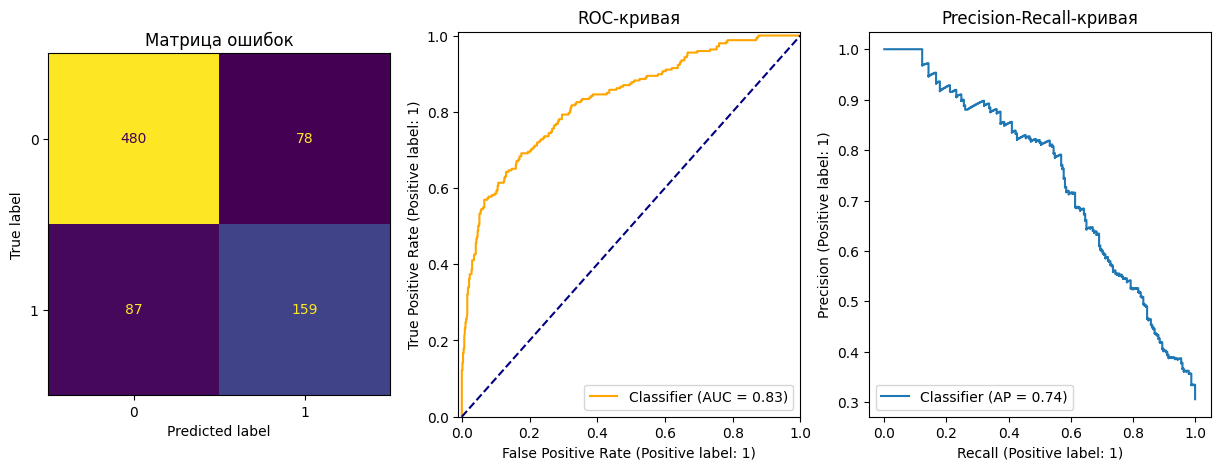

              precision    recall  f1-score   support

           0       0.85      0.86      0.85       558
           1       0.67      0.65      0.66       246

    accuracy                           0.79       804
   macro avg       0.76      0.75      0.76       804
weighted avg       0.79      0.79      0.79       804



In [20]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    ax=axes[0],
    colorbar=False,
)
axes[0].set(title='Матрица ошибок')

RocCurveDisplay.from_predictions(
    y_test, y_proba,
    ax=axes[1],
    color='orange',
)
axes[1].plot([0, 1], [0, 1], color='navy', linestyle='--')
axes[1].set(title='ROC-кривая', xlim=(-0.01, 1), ylim=(0, 1.01))

PrecisionRecallDisplay.from_predictions(
    y_test, y_proba,
    ax=axes[2],
)
axes[2].set(title='Precision-Recall-кривая')

plt.show()

print(classification_report(y_test, y_pred))

## Общий вывод

[к навигации](#Навигация)

Построили модель для предложения тарифа клиенту на RandomForest c перфомансом на тестовой выборке `ROC-AUC = 0.83`.

Можно ещё попробовать построить модель на GBDT (`CatBoost`/`LightGBM`) с оптимизацией гиперпараметров через `optuna`.
Этот подход должен увеличить перфоманс модели.